<a href="https://colab.research.google.com/github/jychen630/dl-fall22-mini-project/blob/main/Dennis_Mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!pip install -e git+https://github.com/marcoancona/TorchPruner.git#egg=torchpruner

In [3]:
import ssl
def set_up_ssl():
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

set_up_ssl()

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import argparse

import matplotlib.pyplot as plt

In [5]:
import os
import sys
import time
import math
import torch.nn as nn
import torch.nn.init as init

term_width = 5
TOTAL_BAR_LENGTH = 7
last_time = time.time()
begin_time = last_time
def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

In [6]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        # pruning model parameters in the first convolution layer

        # prune.random_unstructured(self.conv1, name='weight', amount=0.6)
        # prune.remove(self.conv1, 'weight')

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        # pruning model parameters in the second convolution layer

        # prune.random_unstructured(self.conv2, name='weight', amount=0.6)
        # prune.remove(self.conv2, 'weight')

        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)

        # prune.random_unstructured(self.conv1, name='weight', amount=0.5)
        # prune.remove(self.conv1, 'weight')

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        
        # prune.random_unstructured(self.conv2, name='weight', amount=0.5)
        # prune.remove(self.conv2, 'weight')

        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        
        # prune.random_unstructured(self.conv3, name='weight', amount=0.5)
        # prune.remove(self.conv3, 'weight')

        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        
        # prune.random_unstructured(self.conv1, name='weight', amount=0.5)
        # prune.remove(self.conv1, 'weight')

        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        # removing the 4th layer to reduce the size of the network
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

        # prune.random_unstructured(self.linear, name='weight', amount=0.5)
        # prune.remove(self.linear, 'weight')

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # removing the 4th layer to reduce the size of the network
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


#seems not used
# def test():
#     net = ResNet18()
#     y = net(torch.randn(1, 3, 32, 32))
#     print(y.size())


In [7]:
from torch.utils.data import random_split

LOCAL_M1 = False

if LOCAL_M1:
    device = 'cuda' if torch.cuda.is_available() else 'mps'
else:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    #transforms.RandomErasing()

   
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# constructing validation set

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

torch.manual_seed(43)
val_size = 5000
train_size = len(trainset) - val_size

train_ds, val_ds = random_split(trainset, [train_size, val_size])
len(train_ds), len(val_ds)
print("The length of a train set is ", len(train_ds))
print("The length of a validation set is ", len(val_ds))
print("The length of a test set is ", len(testset))

trainloader = torch.utils.data.DataLoader(
    train_ds, batch_size=128, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=128, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

net = ResNet18() # 11.2 params
#net = ResNet50() # 23.5

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
The length of a train set is  45000
The length of a validation set is  5000
The length of a test set is  10000


In [8]:
layers = list(net.children())

print(len(layers))

print("layers[0]: ", layers[0])
print("layers[1]: ", layers[1])
print("layers[2]: ", layers[2])
print("layers[3]: ", layers[3])
print("layers[4]: ", layers[4])
print("layers[5]: ", layers[5])
print("layers[6]: ", layers[6])

7
layers[0]:  Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layers[1]:  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layers[2]:  Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [9]:
!git clone https://github.com/VainF/Torch-Pruning.git # recommended
!pip3 install torch_pruning

fatal: destination path 'Torch-Pruning' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import torch_pruning as tp

def prune_model(model):
    model.cpu()
    DG = tp.DependencyGraph().build_dependency( model, torch.randn(1, 3, 32, 32) )
    def prune_conv(conv, amount=0.2):
        strategy = tp.strategy.L1Strategy()
        pruning_index = strategy(conv.weight, amount=amount)
        plan = DG.get_pruning_plan(conv, tp.prune_conv_out_channel, pruning_index)
        plan.exec()
    
    block_prune_probs = [0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3]
    blk_id = 0
    for m in model.modules():
        if isinstance( m, BasicBlock):
            prune_conv( m.conv1, block_prune_probs[blk_id] )
            prune_conv( m.conv2, block_prune_probs[blk_id] )
            blk_id+=1
    return model   

In [11]:
from torchsummary import summary
import humanize

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_params(model):
  print("Number of parameters ", humanize.intword(count_parameters(model)))
  return

In [12]:
print("The number of parameters before pruning is ")
print_params(net)

The number of parameters before pruning is 
Number of parameters  11.2 million


In [13]:
prune_model(net)

ResNet(
  (conv1): Conv2d(3, 53, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(53, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(53, 58, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(58, 53, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(53, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(53, 58, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(58, 53, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(53, eps=1e-05, momentum=0.1, affine=

In [14]:
print("The number of parameters after pruning is ")
print_params(net)

The number of parameters after pruning is 
Number of parameters  4.5 million


In [15]:
# from torchpruner import (Pruner, ShapleyAttributionMetric)

In [16]:
def get_pruned_parameters_countget_pruned_parameters_count(pruned_model):
    params = 0
    for param in pruned_model.parameters():
        if param is not None:
            params += torch.nonzero(param).size(0)
    return params

In [17]:
from torchsummary import summary

def print_model_summary(model):
  print(summary(model.to(device), (3, 32, 32)))

print_model_summary(net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 53, 32, 32]           1,431
       BatchNorm2d-2           [-1, 53, 32, 32]             106
            Conv2d-3           [-1, 58, 32, 32]          27,666
       BatchNorm2d-4           [-1, 58, 32, 32]             116
            Conv2d-5           [-1, 53, 32, 32]          27,666
       BatchNorm2d-6           [-1, 53, 32, 32]             106
        BasicBlock-7           [-1, 53, 32, 32]               0
            Conv2d-8           [-1, 58, 32, 32]          27,666
       BatchNorm2d-9           [-1, 58, 32, 32]             116
           Conv2d-10           [-1, 53, 32, 32]          27,666
      BatchNorm2d-11           [-1, 53, 32, 32]             106
       BasicBlock-12           [-1, 53, 32, 32]               0
           Conv2d-13          [-1, 103, 16, 16]          49,131
      BatchNorm2d-14          [-1, 103,

In [18]:
def print_model_layers(model):
  for name, param in model.named_parameters():
    print(name, param.size())

print_model_layers(net)

conv1.weight torch.Size([53, 3, 3, 3])
bn1.weight torch.Size([53])
bn1.bias torch.Size([53])
layer1.0.conv1.weight torch.Size([58, 53, 3, 3])
layer1.0.bn1.weight torch.Size([58])
layer1.0.bn1.bias torch.Size([58])
layer1.0.conv2.weight torch.Size([53, 58, 3, 3])
layer1.0.bn2.weight torch.Size([53])
layer1.0.bn2.bias torch.Size([53])
layer1.1.conv1.weight torch.Size([58, 53, 3, 3])
layer1.1.bn1.weight torch.Size([58])
layer1.1.bn1.bias torch.Size([58])
layer1.1.conv2.weight torch.Size([53, 58, 3, 3])
layer1.1.bn2.weight torch.Size([53])
layer1.1.bn2.bias torch.Size([53])
layer2.0.conv1.weight torch.Size([103, 53, 3, 3])
layer2.0.bn1.weight torch.Size([103])
layer2.0.bn1.bias torch.Size([103])
layer2.0.conv2.weight torch.Size([83, 103, 3, 3])
layer2.0.bn2.weight torch.Size([83])
layer2.0.bn2.bias torch.Size([83])
layer2.0.shortcut.0.weight torch.Size([83, 53, 1, 1])
layer2.0.shortcut.1.weight torch.Size([83])
layer2.0.shortcut.1.bias torch.Size([83])
layer2.1.conv1.weight torch.Size([103

In [19]:
def freeze_layer(layer_name):
  for param_name, param in net.named_parameters():
    if layer_name in param_name:
      param.requires_grad = False

In [20]:
# freeze_layer("layer3")

In [21]:
print_model_summary(net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 53, 32, 32]           1,431
       BatchNorm2d-2           [-1, 53, 32, 32]             106
            Conv2d-3           [-1, 58, 32, 32]          27,666
       BatchNorm2d-4           [-1, 58, 32, 32]             116
            Conv2d-5           [-1, 53, 32, 32]          27,666
       BatchNorm2d-6           [-1, 53, 32, 32]             106
        BasicBlock-7           [-1, 53, 32, 32]               0
            Conv2d-8           [-1, 58, 32, 32]          27,666
       BatchNorm2d-9           [-1, 58, 32, 32]             116
           Conv2d-10           [-1, 53, 32, 32]          27,666
      BatchNorm2d-11           [-1, 53, 32, 32]             106
       BasicBlock-12           [-1, 53, 32, 32]               0
           Conv2d-13          [-1, 103, 16, 16]          49,131
      BatchNorm2d-14          [-1, 103,

In [22]:
print("The total number of parameters before the pruning is ")
print_params(net)

The total number of parameters before the pruning is 
Number of parameters  4.5 million


In [23]:
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

lr = 0.1
lr = 0.01
criterion = nn.CrossEntropyLoss()

#optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=5e-4)
optimizer = optim.SGD(net.parameters(), lr=lr,
                       momentum=0.9, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

save_loss = {'train':[], 'test':[]}
save_acc = {'train':[], 'test':[]}

train_acc_array, train_loss_array = [], [] # for plotting
val_acc_array, val_loss_array = [], [] # for plotting

In [24]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    train_acc = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        train_acc=100.*correct/total
        progress_bar(batch_idx, len(trainloader), 'Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

    train_acc_array.append(train_acc) # for plottting
    train_loss_array.append(train_loss) # for plottting


In [25]:
def evaluate(epoch): # validation
   
    global best_acc
    net.eval()
    valid_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
          
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(val_loader), 'Valid Loss: %.3f | Valid Acc: %.3f%% (%d/%d)'
                         % (valid_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    valid_acc = 100.*correct/total
    if valid_acc > best_acc:
        print('Saving..')
        state = {
            'net_state_dict': net.state_dict(),
            'acc': valid_acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        #torch.save(state, './model.pt')
        best_acc = valid_acc
    val_acc_array.append(valid_acc) # for plottting
    val_loss_array.append(valid_loss) # for plottting

In [26]:
# Load the best model parameters (measured in terms of validation loss) and evaluate the loss/accuracy on the test set.
def test(): 
   
    test_loss = 0
    correct = 0
    total = 0
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net_state_dict'])
    best_epoch = checkpoint['epoch']
    best_acc = checkpoint['acc']
    net.eval()
    print(f'Best validation acc: {best_acc:.3f}% at Epoch {best_epoch}')
    with torch.no_grad():
          
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs) 
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))


In [27]:
print("Using device ", device)

Using device  cuda


In [28]:
print_params(net)

Number of parameters  4.5 million


In [29]:
NUM_EPOCHS = 20

for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
    train(epoch)
    evaluate(epoch)
    scheduler.step()

print('---------------------------------------- Testing Model... ----------------------------------------')
test()


Epoch: 0
 [======>]  Step: 520ms | Tot: 46s96ms | Train Loss: 1.765 | TrainAcc: 34.811% (15665/45000) 352/352 
 [======>]  Step: 101ms | Tot: 3s451ms | Valid Loss: 1.615 | Valid Acc: 42.760% (2138/5000) 40/40 
Saving..

Epoch: 1
 [======>]  Step: 51ms | Tot: 50s772ms | Train Loss: 1.281 | TrainAcc: 54.160% (24372/45000) 352/352 
 [======>]  Step: 14ms | Tot: 4s374ms | Valid Loss: 1.265 | Valid Acc: 54.540% (2727/5000) 40/40 
Saving..

Epoch: 2
 [======>]  Step: 69ms | Tot: 42s31ms | Train Loss: 1.031 | TrainAcc: 64.000% (28800/45000) 352/352 
 [======>]  Step: 14ms | Tot: 3s248ms | Valid Loss: 1.091 | Valid Acc: 61.800% (3090/5000) 40/40 
Saving..

Epoch: 3
 [======>]  Step: 102ms | Tot: 40s854ms | Train Loss: 0.906 | TrainAcc: 68.138% (30662/45000) 352/352 
 [======>]  Step: 18ms | Tot: 6s379ms | Valid Loss: 0.962 | Valid Acc: 66.640% (3332/5000) 40/40 
Saving..

Epoch: 4
 [======>]  Step: 52ms | Tot: 43s725ms | Train Loss: 0.817 | TrainAcc: 71.480% (3

In [50]:
train_acc_array = [34.811,54.160,64.000,68.138,71.480,73.927,75.189,76.938,78.153,78.724,79.958,80.922,81.207,82.047,82.607,82.836,83.582,83.962,84.358,84.576 ]

In [30]:
print_params(net)

Number of parameters  4.5 million


In [31]:
net.parameters()

<generator object Module.parameters at 0x7fee585df8d0>

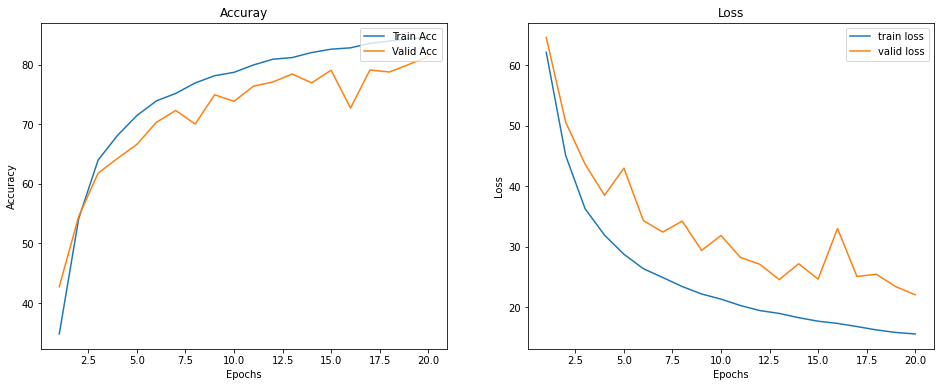

In [51]:
import numpy as np

fig = plt.figure(figsize=(16,6))

plt.subplot(121)
plt.plot(np.arange(1,NUM_EPOCHS+1),train_acc_array)
plt.plot(np.arange(1,NUM_EPOCHS+1),val_acc_array)
plt.title("Accuray")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train Acc","Valid Acc"],loc = "upper right")


plt.subplot(122)
plt.plot(np.arange(1,NUM_EPOCHS+1),train_loss_array)
plt.plot(np.arange(1,NUM_EPOCHS+1),val_loss_array)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train loss', 'valid loss'], loc="upper right")

plt.show()

In [32]:
# can you create a subset of params exclusing pruned weights ?